In [165]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os

import sys
sys.path.append('../../')
from cad.calc.geo import Geo
from cad.calc.conv import freq_to_note_and_cent, note_name
import pandas as pd
import seaborn as sns

import json

def do_fft(infile, size=-1, maxfreq=1000):
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    if size == -1:
        size=len(signal)
    
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]
    #fft_spectrum_abs = np.log2(fft_spectrum_abs)

    return freq, fft_spectrum_abs




Malveira


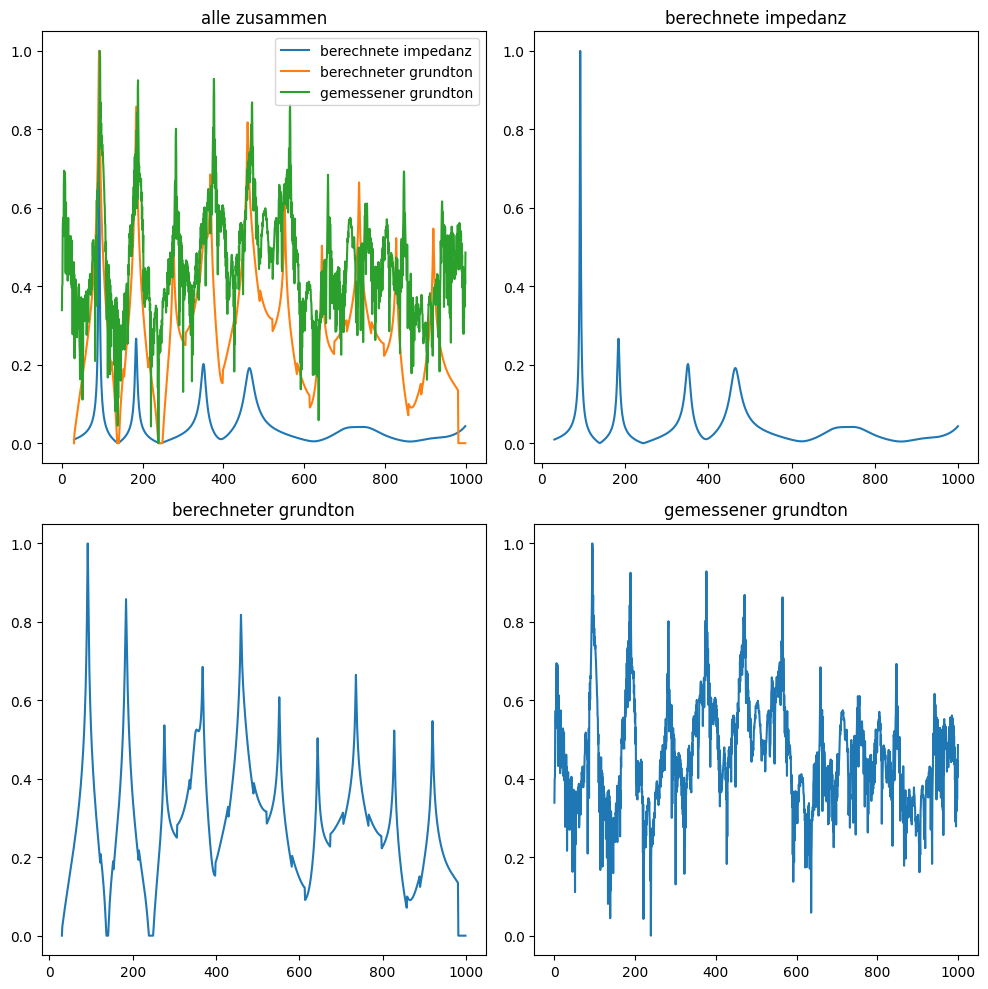

In [2]:
import json

archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))

def get_maxima(freq, signal, n):
    
    if type(freq) is not np.array:
        freq = np.array(freq)
    if type(signal) is not np.array:
        signal = np.array(signal)
    
    max_indizes = np.array(argrelextrema(signal, np.greater)[0])
    max_indizes = sorted(max_indizes, key=lambda x : signal[x])
    i_maxima = max_indizes[-1*n:]
    maxima = [freq[m] for m in i_maxima]
    #maxima = sorted(maxima)
    return maxima, i_maxima

def difference_plot(sound_file : str, geo : list, didge_name=None):
    
    geo = Geo(geo)
    cadsd = geo.get_cadsd()

    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    
    impedance_spektrum = cadsd.get_impedance_spektrum()
    impedance_freqs = impedance_spektrum.freq
    impedance_amps = impedance_spektrum.impedance
    
    impedance_amps -= impedance_amps.min()
    impedance_amps /= impedance_amps.max()

    freq, fft_spectrum_abs = do_fft(sound_file)
    fft_spectrum_abs = np.log2(fft_spectrum_abs)
    fft_spectrum_abs -= fft_spectrum_abs.min()
    fft_spectrum_abs /= fft_spectrum_abs.max()
    
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    
    axs[0,0].plot(impedance_freqs, impedance_amps, label="berechnete impedanz")
    axs[0,0].plot(ground_freqs, ground_vols, label="berechneter grundton")
    axs[0,0].plot(freq, fft_spectrum_abs, label="gemessener grundton")
    axs[0,0].set_title("alle zusammen")
    axs[0,0].legend()
    
    axs[0,1].plot(impedance_freqs, impedance_amps)
    axs[0,1].set_title("berechnete impedanz")
    
    axs[1,0].plot(ground_freqs, ground_vols)
    axs[1,0].set_title("berechneter grundton")
    
    axs[1,1].plot(freq, fft_spectrum_abs)
    axs[1,1].set_title("gemessener grundton")

    #maxima, i_maxima = get_maxima(freq, fft_spectrum_abs, 12)
    #for m in maxima:
    #    axs[1,1].axvline(x=m, color="red")    
    
    

    fig.tight_layout()

    
didge = archive[0]
geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])

print(didge["name"])
difference_plot(sound_file, geo, didge_name=didge["name"])    

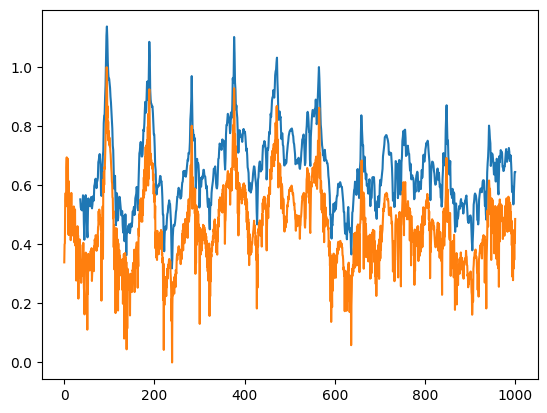

In [18]:
def quantize(freq, amp, size=1, min_freq=35, max_freq=1000):
    qfreqs = np.arange(min_freq, max_freq, size) + size/2
    qamps = []
    for f in qfreqs:
        window = (freq>f-size) & (freq<f+size)
        qamps.append(np.mean(amp[window]))
    qamps = np.array(qamps)
    return qfreqs, qamps

didge = archive[0]
geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])

freq, fft_spectrum_abs = do_fft(sound_file)
fft_spectrum_abs = np.log2(fft_spectrum_abs)
fft_spectrum_abs -= fft_spectrum_abs.min()
fft_spectrum_abs /= fft_spectrum_abs.max()

qfreq, qamps = quantize(freq, fft_spectrum_abs)

plt.plot(qfreq, qamps+0.2, label="quantized")
plt.plot(freq, fft_spectrum_abs, label="original")
#plt.legend()

In [24]:
def ground_spectrum_difference(sound_file : str, geo : list):
    """Return the difference between the computed and measured ground sound spektra.

    Args:
        sound_file (str): _description_
        geo (list): _description_

    Returns:
        _type_: _description_
    """
    geo = Geo(geo)
    cadsd = geo.get_cadsd()

    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    
    freq, fft_spectrum_abs = do_fft(sound_file)
    fft_spectrum_abs = np.log2(fft_spectrum_abs)
    fft_spectrum_abs -= fft_spectrum_abs.min()
    fft_spectrum_abs /= fft_spectrum_abs.max()

    ground_freqs, ground_vols = quantize(ground_freqs, ground_vols)
    freqs, fft_spectrum = quantize(freq, fft_spectrum_abs)

    diff = [np.power(ground_vols[i]-fft_spectrum[i], 2) for i in range(len(ground_vols))]
    diff = np.sqrt(np.sum(diff))
    return diff

r = []
for i in range(len(archive)):
    row = []
    for j in range(len(archive)):
        didge = archive[i]
        geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
        didge = archive[j]
        sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])

        diff = ground_spectrum_difference(sound_file, geo)
        row.append(diff)
    r.append(row)
    
df = pd.DataFrame(r)
df

,0,1,2,3,4
0,6.410826,7.450078,7.754907,7.631192,8.963032
1,8.559184,7.164949,7.717134,6.811320,8.678479
2,7.659280,6.878294,6.593546,6.022263,7.764018
3,7.169361,6.861385,7.270717,6.013673,8.205264
4,6.941617,6.698209,6.429341,6.125676,7.480607


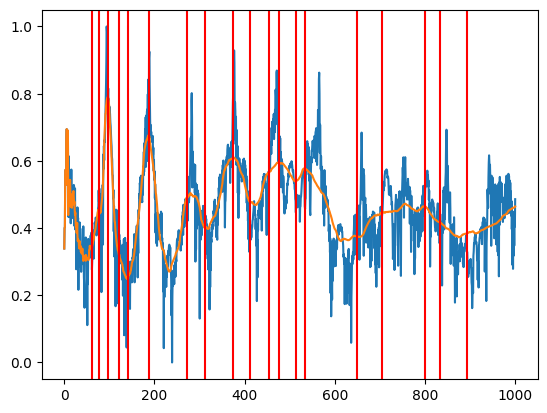

In [94]:
## import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os
import sys
import pandas as pd
import seaborn as sns
import json

#from cad.calc.geo import Geo
#from cad.calc.conv import freq_to_note_and_cent, note_name

# analyze peaks from the record
def do_fft(infile, maxfreq=1000):
    """Compute FFT of an audiofile.

    Args:
        infile (_type_): audiofile
        maxfreq (int, optional): maximal frequency. Defaults to 1000.

    Returns:
        _type_: list of frequencies‚ and list of amplitudes.
    """
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    size=len(signal)
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]

    return freq, fft_spectrum_abs

def window_average(freq, fft_spectrum, window_size = 0.1 ):
    """Average fft_spectrum with a sliding window technique for low pass filtering.
   
        freq (_type_): list of frequency values
        fft_spectrum (_type_): list of fft values for the frequency values
        window_size (float, optional): The window_size as a fraction of an octave. Defaults to 0.1.

    Returns:
        _type_: The averaged fft spectrum.
    """
    averaged_fft_spectrum = []
    _freq = freq.copy()
    zeros = _freq==0
    _freq[zeros] = 1
    log_freq = np.log2(_freq)
    log_freq[zeros] = 0
    for i in range(len(fft_spectrum)):
        window = (log_freq>log_freq[i]-window_size) & (log_freq<log_freq[i]+window_size)
        avg = np.mean(fft_spectrum[window])
        averaged_fft_spectrum.append(avg)
    averaged_fft_spectrum = np.array(averaged_fft_spectrum)
    return averaged_fft_spectrum

# retrieve all local maxima 
# also merge maxima that are close to each other
def get_maxima(freq, averaged_fft_spectrum, min_freq=60):
    """Retrieve all local maxima. Also merge maxima that are close to each other.

    Args:
        freq (_type_): List of frequencies
        averaged_fft_spectrum (_type_): List of amplitudes.
        min_freq (_type_): Ignore clusterr below min_freq

    Returns:
        _type_: list of integers of the positions of the maxima
    """
    i_maxima = argrelextrema(averaged_fft_spectrum, np.greater)[0]
    
    i_maxima = np.array(i_maxima)
    
    maxima = freq[i_maxima]
    maxima = maxima[maxima>min_freq]
    log_max = np.log2(maxima)

    counter=0
    len_clusters_before = -1
    stop = False

    while not stop:
        counter+=1
        if counter==200:
            break

        distance_matrix = []
        for y in range(len(log_max)):
            row = []
            for x in range(len(log_max)):
                row.append(np.abs(log_max[x] - log_max[y]))
            distance_matrix.append(row)    
        distance_matrix = np.array(distance_matrix)

        clusters = []
        for i in range(len(distance_matrix)):
            c = np.arange(len(distance_matrix))[distance_matrix[i]<0.05]
            clusters.append(c)

        clusters = {str(c):c for c in clusters}.values() # duplicate removal
        clusters = list(clusters)

        for i in range(len(clusters)):
            cluster_amplitudes = averaged_fft_spectrum[i_maxima[clusters[i]]]
            max_i = np.argmax(cluster_amplitudes)
            clusters[i] = clusters[i][max_i]

        clusters=np.array([int(x) for x in clusters])

        maxima = maxima[clusters]
        log_max = np.log2(maxima)

        if len_clusters_before == len(clusters):
            break
        len_clusters_before = len(clusters)

    return maxima
      
sound_file = os.path.join(archive_path, archive[i]["audio-samples"]["neutral-sound"])
freq, fft_spectrum_abs = do_fft(sound_file)
fft_spectrum_abs = np.log2(fft_spectrum_abs)
fft_spectrum_abs -= fft_spectrum_abs.min()
fft_spectrum_abs /= fft_spectrum_abs.max()

plt.plot(freq, fft_spectrum_abs, label=f"gemessen")
averaged_fft_spectrum = window_average(freq, fft_spectrum_abs)
plt.plot(freq, averaged_fft_spectrum, label="averaged")

min_freq = 60

fft_maxima = get_maxima(freq, averaged_fft_spectrum, min_freq)

for m in fft_maxima:
    #j = np.argmin(np.abs(freq-))
    plt.axvline(x=m, color="red") 


In [200]:
freq, spectrum = do_fft(sound_file)
spectrum = np.log2(fft_spectrum_abs)
spectrum -= fft_spectrum_abs.min()
spectrum /= fft_spectrum_abs.max()

def get_harmonic_maxima(freq, spectrum, min_freq=60):
    i=0
    maxima = []
    base_freq = 0
    while i*window_freq<1000:
        if i==0:
            window = freq>min_freq
        else:
            window = (freq>(i+0.5)*base_freq) & (freq<base_freq*(i+1.5))

        if window.astype(int).sum() == 0:
            break
        window_f = freq[window]
        window_s = spectrum[window]
        maxi = np.argmax(window_s)
        max_f = window_f[maxi]
        if i==0:
            base_freq=max_f

        maxima.append(max_f)
        i+=1
    return maxima


i=1

geo = json.load(open(os.path.join(archive_path, archive[i]["geometry"]), "r"))
geo = Geo(geo)
cadsd = geo.get_cadsd()
ground_spektrum=cadsd.get_ground_spektrum()
ground_freqs = np.array(list(ground_spektrum.keys()))
ground_vols = np.array(list(ground_spektrum.values()))
ground_vols -= ground_vols.min()
ground_vols /= ground_vols.max()


ground_maxima = get_harmonic_maxima(ground_freqs, ground_vols)
print(ground_maxima)

 
#get_harmonic_maxima(freq, averaged_fft_spectrum)
#plt.plot(freq, spectrum)
#maxima = get_harmonic_maxima(freq, spectrum)
#for m in maxima:
#    plt.axvline(x=m, color="red")

[73, 146, 219, 292, 365, 438, 511, 584, 657, 730, 803, 876, 949, 986]


/var/folders/x2/b40hstxn35z830rfs3b1ncrc0000gp/T/ipykernel_49473/3638611622.py:2: RuntimeWarning: divide by zero encountered in log2
  spectrum = np.log2(fft_spectrum_abs)


In [224]:
window_freq

60

In [ ]:
computed_maxima = []
measured_maxima = []
for i in range(len(archive)):
    fft_maxima = get_harmonic_maxima(freq, spectrum)
    measured_maxima.append(fft_maxima)
    ground_maxima = get_harmonic_maxima(ground_freqs, ground_vols)
    computed_maxima.append(ground_maxima)


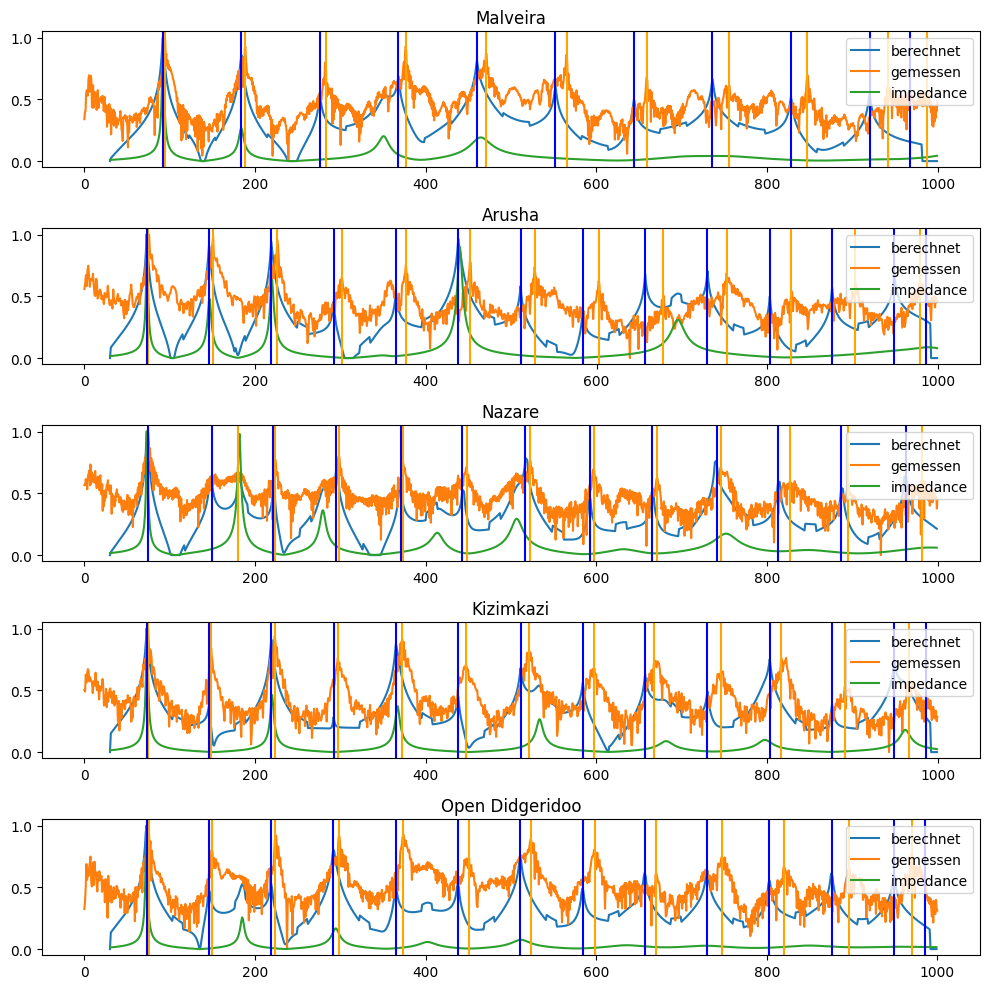

In [171]:
fig, axs = plt.subplots(len(archive), 1, figsize=(10,10))

didges = []

computed_maxima = []
measured_maxima = []
for i in range(len(archive)):
    geo = json.load(open(os.path.join(archive_path, archive[i]["geometry"]), "r"))
    geo = Geo(geo)
    cadsd = geo.get_cadsd()
    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    axs[i].plot(ground_freqs, ground_vols, label="berechnet")

    sound_file = os.path.join(archive_path, archive[i]["audio-samples"]["neutral-sound"])
    freq, spectrum = do_fft(sound_file)
    spectrum = np.log2(spectrum)
    spectrum -= spectrum.min()
    spectrum /= spectrum.max()

    axs[i].plot(freq, spectrum, label=f"gemessen")
    
    impedance_spektrum = cadsd.get_impedance_spektrum()
    impedance_freqs = impedance_spektrum.freq
    impedance_amps = impedance_spektrum.impedance
    impedance_amps -= impedance_amps.min()
    impedance_amps /= impedance_amps.max()
    axs[i].plot(impedance_freqs, impedance_amps, label=f"impedance")

    fft_maxima = get_harmonic_maxima(freq, spectrum)
    measured_maxima.append(fft_maxima)
    for m in fft_maxima:
        axs[i].axvline(x=m, color="orange") 
        
    ground_maxima = get_harmonic_maxima(ground_freqs, ground_vols)
    computed_maxima.append(ground_maxima)
    for m in ground_maxima:
        axs[i].axvline(x=m, color="blue")

    axs[i].legend()
    axs[i].set_title(archive[i]["name"])
        
fig.tight_layout()

In [189]:
# compute correction term
for i in range(len(archive)):
    l = min(len(computed_maxima[i]), len(measured_maxima[i]))
    measured_maxima[i] = measured_maxima[i][0:l]
    computed_maxima[i] = computed_maxima[i][0:l]
    
def rms_error(measured_maxima, computed_maxima):
    error = 0
    for i in range(len(measured_maxima)):
        y = np.array(measured_maxima[i]) - np.array(computed_maxima[i])
        y = np.power(y, 2).sum()
        y = np.sqrt(y) / len(measured_maxima[i])
        error += y
    error /= len(measured_maxima)
    return error

X = np.concatenate(computed_maxima)
y = np.concatenate(measured_maxima)-np.concatenate(computed_maxima)

X = np.reshape(X, (-1, 1))
print(rms_error(measured_maxima, computed_maxima))


3.870223471611952


In [191]:
from sklearn import svm

regr = svm.SVR()
regr.fit(X, y)


array([ 4.25710155,  4.60464871,  6.24268495,  8.58006168, 10.93532352,
       12.94920705, 14.62371567, 16.01100804, 16.92317061, 17.01631633,
       16.69037664,  4.36318486,  4.28625707,  5.09967526,  6.61989714,
        8.50042939, 10.3969025 , 12.09946593, 13.56457572, 14.8383171 ,
       15.93151029, 16.74251088, 17.09145024, 16.84401922,  4.35616812,
        4.30257109,  5.13326367,  6.69267138,  8.6596793 , 10.52104184,
       12.22847124, 13.73091451, 14.96771322, 16.07577189, 16.82175632,
       17.0938545 , 16.72747245,  4.36318486,  4.28625707,  5.09967526,
        6.61989714,  8.50042939, 10.3969025 , 12.09946593, 13.56457572,
       14.8383171 , 15.93151029, 16.74251088, 17.09145024, 16.84401922,
        4.36318486,  4.28625707,  5.09967526,  6.61989714,  8.50042939,
       10.3969025 , 12.09946593, 13.56457572, 14.8383171 , 15.93151029,
       16.74251088, 17.09145024, 16.84401922])

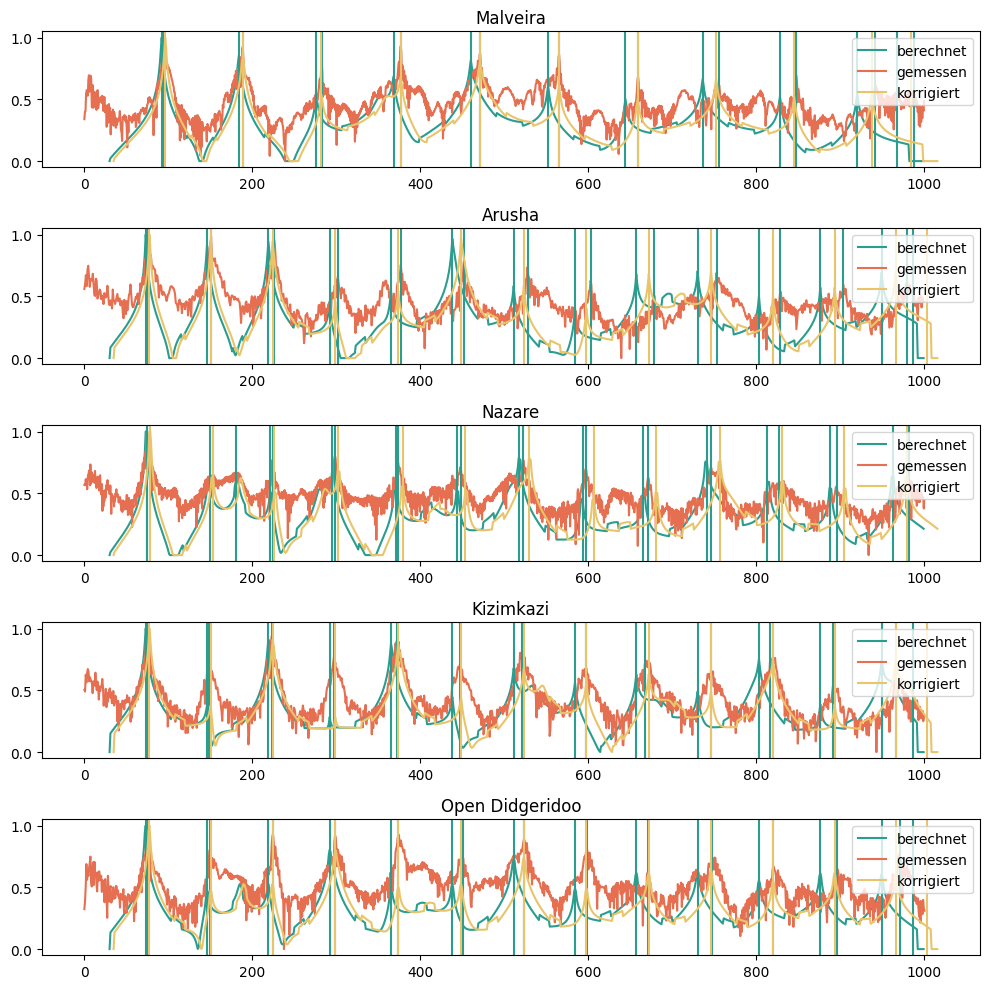

In [223]:
fig, axs = plt.subplots(len(archive), 1, figsize=(10,10))

didges = []

computed_maxima = []
measured_maxima = []

show_computed_ground_spectrum=True
show_computed_impedance_spectrum=False
show_original_fft=True
show_ground_peaks=True
show_fft_peaks=True
show_corrected_ground_spektrum=True
show_corrected_ground_peaks=True

colors = ["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"]
c1=1
c2=4
c3=2

for i in range(len(archive)):
    geo = json.load(open(os.path.join(archive_path, archive[i]["geometry"]), "r"))
    geo = Geo(geo)
    cadsd = geo.get_cadsd()
    
    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    
    if show_computed_ground_spectrum:
        axs[i].plot(ground_freqs, ground_vols, label="berechnet", color=colors[c1])

    sound_file = os.path.join(archive_path, archive[i]["audio-samples"]["neutral-sound"])
    freq, spectrum = do_fft(sound_file)
    spectrum = np.log2(spectrum)
    spectrum -= spectrum.min()
    spectrum /= spectrum.max()

    if show_original_fft:
        axs[i].plot(freq, spectrum, label=f"gemessen", color=colors[c2])
    
    if show_computed_impedance_spectrum:
        impedance_spektrum = cadsd.get_impedance_spektrum()
        impedance_freqs = impedance_spektrum.freq
        impedance_amps = impedance_spektrum.impedance
        impedance_amps -= impedance_amps.min()
        impedance_amps /= impedance_amps.max()
        axs[i].plot(impedance_freqs, impedance_amps, label=f"impedance")

    if show_fft_peaks:
        fft_maxima = get_harmonic_maxima(freq, spectrum)
        measured_maxima.append(fft_maxima)
        for m in fft_maxima:
            axs[i].axvline(x=m, color=colors[c1]) 
        
    if show_ground_peaks:
        ground_maxima = get_harmonic_maxima(ground_freqs, ground_vols)
        computed_maxima.append(ground_maxima)
        for m in ground_maxima:
            axs[i].axvline(x=m, color=colors[c1])
        
    if show_corrected_ground_peaks:
        corrected_maxima_X = np.array(ground_maxima).reshape((-1,1))
        corrected_maxima = ground_maxima + regr.predict(corrected_maxima_X)
        for m in corrected_maxima:
            axs[i].axvline(x=m, color=colors[c3])
            
    if show_corrected_ground_spektrum:
        X = ground_freqs.reshape((-1,1))
        y = regr.predict(X)
        corrected_ground_freqs = ground_freqs + y
        axs[i].plot(corrected_ground_freqs, ground_vols, label=f"korrigiert", color=colors[c3])
        

    axs[i].legend()
    axs[i].set_title(archive[i]["name"])
        
fig.tight_layout()

In [209]:
ground_freqs

array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21